In [ ]:
!pip install transformers datasets nltk scikit-learn pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"sukumarabhishek07","key":"86496a4204b4c0bb0a8e5dd7a2e453c8"}' > ~/.kaggle/kaggle.json
!kaggle datasets download -d mrmorj/hate-speech-and-offensive-language-dataset
!unzip hate-speech-and-offensive-language-dataset.zip


Dataset URL: https://www.kaggle.com/datasets/mrmorj/hate-speech-and-offensive-language-dataset
License(s): CC0-1.0
 99% 1.00M/1.01M [00:00<00:00, 1.09MB/s]
100% 1.01M/1.01M [00:00<00:00, 1.09MB/s]
Archive:  hate-speech-and-offensive-language-dataset.zip
  inflating: labeled_data.csv        


In [ ]:
# Load the dataset
df = pd.read_csv("labeled_data.csv")

# Display first 5 rows
df.head()


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [ ]:
# Take a random sample of 1000 rows
df_small = df.sample(n=1000, random_state=42)

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters and punctuation
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df_small['clean_tweet'] = df_small['tweet'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df_small['label'] = df_small['class'].apply(lambda x: 1 if x in [0, 1] else 0)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df_small['clean_tweet'], df_small['label'], test_size=0.2, random_state=42, stratify=df_small['label']
)


In [ ]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize text
def tokenize_text(texts):
    return tokenizer(
        list(texts),
        padding=True,  # Add padding
        truncation=True,  # Truncate long inputs
        max_length=128,  # Limit input size to 128 tokens
        return_tensors="pt"  # Return PyTorch tensors
    )

train_encodings = tokenize_text(X_train)
test_encodings = tokenize_text(X_test)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class OffensiveLanguageDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        return item

# Convert data into dataset format
train_dataset = OffensiveLanguageDataset(train_encodings, y_train)
test_dataset = OffensiveLanguageDataset(test_encodings, y_test)


In [ ]:
# Load BERT model for binary classification (offensive vs. non-offensive)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,  # Reduce training time
    per_device_train_batch_size=4,  # Use smaller batches
    per_device_eval_batch_size=4,
    warmup_steps=100,  # Lower warmup steps
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=5,
    evaluation_strategy="epoch"
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sukumar-user (sukumar-user-gayatri-vidya-parishad-college-of-engineering) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.456500,0.324205
2,0.005400,0.344297


TrainOutput(global_step=400, training_loss=0.31944457344943655, metrics={'train_runtime': 96.6217, 'train_samples_per_second': 16.559, 'train_steps_per_second': 4.14, 'total_flos': 46044434688000.0, 'train_loss': 0.31944457344943655, 'epoch': 2.0})

In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.34429672360420227,
 'eval_runtime': 0.7604,
 'eval_samples_per_second': 263.014,
 'eval_steps_per_second': 65.754,
 'epoch': 2.0}

In [ ]:
model.save_pretrained("offensive_language_model")
tokenizer.save_pretrained("offensive_language_model")


('offensive_language_model/tokenizer_config.json',
 'offensive_language_model/special_tokens_map.json',
 'offensive_language_model/vocab.txt',
 'offensive_language_model/added_tokens.json')

In [ ]:
def predict_offensive_text(text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Use GPU if available
    model.to(device)  # Move model to the correct device

    # Move input tensors to the same device as the model
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)

    outputs = model(**inputs)  # Forward pass
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)

    label = torch.argmax(predictions).item()
    return "Offensive" if label == 1 else "Non-Offensive"

# Test a sample tweet
test_tweet = "Hi I am Sukumar"
print(predict_offensive_text(test_tweet))


Non-Offensive


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import numpy as np

# Function to get predictions
def get_predictions(dataset):
    predictions = trainer.predict(dataset)
    preds = torch.argmax(torch.tensor(predictions.predictions), dim=1).numpy()
    return preds


Model Accuracy: 93.50%


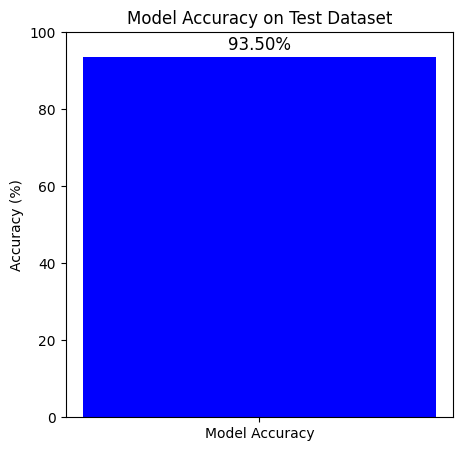

In [ ]:
# Get model predictions on the test dataset
y_pred = get_predictions(test_dataset)

# Convert y_test (pandas Series) to numpy array
y_true = y_test.to_numpy()

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print accuracy
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# Plot Accuracy as a Bar Graph
plt.figure(figsize=(5, 5))
plt.bar(["Model Accuracy"], [accuracy * 100], color='blue')

# Labeling
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy on Test Dataset")
plt.text(0, accuracy * 100 + 2, f"{accuracy * 100:.2f}%", ha='center', fontsize=12)

# Show the plot
plt.show()

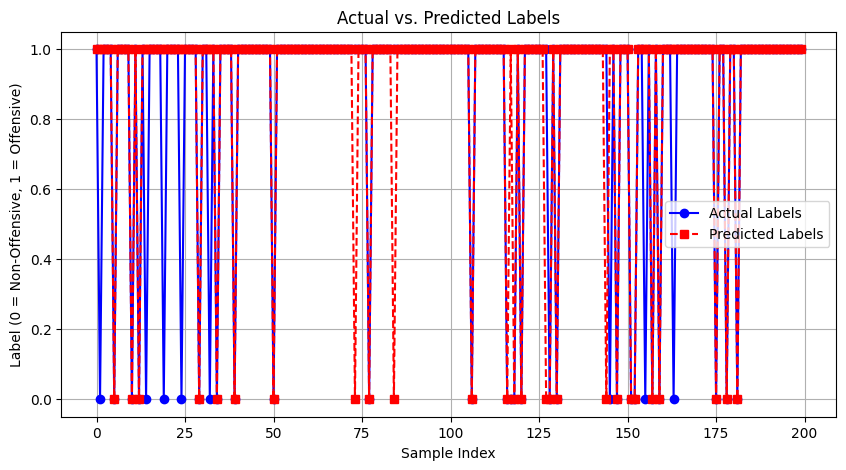

In [ ]:
# Create indices for plotting
indices = np.arange(len(y_true))  # Index numbers for each test sample

# Plot actual and predicted values
plt.figure(figsize=(10, 5))
plt.plot(indices, y_true, label="Actual Labels", marker='o', linestyle='-', color='blue')
plt.plot(indices, y_pred, label="Predicted Labels", marker='s', linestyle='--', color='red')

# Labeling
plt.xlabel("Sample Index")
plt.ylabel("Label (0 = Non-Offensive, 1 = Offensive)")
plt.title("Actual vs. Predicted Labels")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



In [ ]:
!pip install streamlit pyngrok


In [ ]:
%%writefile app.py
import streamlit as st
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the trained model
model_path = "offensive_language_model"  # Change to your actual model path
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Function to predict offensive text
def predict_offensive_text(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    label = torch.argmax(predictions).item()
    return "Offensive" if label == 1 else "Non-Offensive"

# Streamlit UI
st.title("🔍 Offensive Language Detection")
st.write("Enter a text, and the model will classify it as **Offensive** or **Non-Offensive**.")

user_input = st.text_area("Enter text here:")

if st.button("Detect"):
    if user_input.strip():
        prediction = predict_offensive_text(user_input)
        st.write(f"### Prediction: {prediction}")
    else:
        st.warning("Please enter some text before clicking Detect.")


ModuleNotFoundError: No module named 'streamlit'

In [ ]:
!ngrok authtoken 2tt31Kl75uEkbklCM5uiVsC2EK9_6W2qDMzQAbpUue1mjxbVg

/bin/bash: line 1: ngrok: command not found


In [ ]:
import time
from pyngrok import ngrok

# Kill any previous ngrok connections
ngrok.kill()

# Start Streamlit in the background and suppress output
!nohup streamlit run app.py --server.port 8501 > /dev/null 2>&1 &

# Wait for Streamlit to start
time.sleep(5)

# Start ngrok tunnel
public_url = ngrok.connect(8501).public_url

print(f"🚀 Web App is Live at: {public_url}")


🚀 Web App is Live at: https://22fc-35-247-163-18.ngrok-free.app


In [ ]:
!pkill -9 streamlit
